<a href="https://colab.research.google.com/github/IT21373770/24_25J_182-Adaptive-Pedestrian-Crossing-System/blob/IT21184444-sumanasekara/person_ditect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import preprocessing
import cv2
import glob
import os
import warnings as wr

wr.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
train_path = '/content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages'
train_annot = '/content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/Annotations'

test_path = '/content/drive/My Drive/Colab Notebooks/pedestrians dataset/Test/Test/JPEGImages'
test_annot = '/content/drive/My Drive/Colab Notebooks/pedestrians dataset/Test/Test/Annotations'

val_path = '/content/drive/My Drive/Colab Notebooks/pedestrians dataset/Val/Val/JPEGImages'
val_annot = '/content/drive/My Drive/Colab Notebooks/pedestrians dataset/Val/Val/Annotations'


In [9]:
def creatingInfoData(Annotpath):
    information={'xmin':[],'ymin':[],'xmax':[],'ymax':[],'ymax':[],'name':[]
                ,'label':[]}

    for file in sorted(glob.glob(str(Annotpath+'/*.xml*'))):
        dat=ET.parse(file)
        for element in dat.iter():

            if 'object'==element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text
                        information['label'] += [name]
                        information['name'] +=[file.split('/')[-1][0:-4]]

                    if 'bndbox'==attribute.tag:
                        for dim in list(attribute):
                            if 'xmin'==dim.tag:
                                xmin=int(round(float(dim.text)))
                                information['xmin']+=[xmin]
                            if 'ymin'==dim.tag:
                                ymin=int(round(float(dim.text)))
                                information['ymin']+=[ymin]
                            if 'xmax'==dim.tag:
                                xmax=int(round(float(dim.text)))
                                information['xmax']+=[xmax]
                            if 'ymax'==dim.tag:
                                ymax=int(round(float(dim.text)))
                                information['ymax']+=[ymax]

    return pd.DataFrame(information)

In [10]:
train_info=creatingInfoData(train_annot)
test_info=creatingInfoData(test_annot)
val_info=creatingInfoData(val_annot)

In [11]:
train_info.head(20)

,xmin,ymin,xmax,ymax,name,label
0,158,44,289,167,image (1),person
1,185,56,287,241,image (10),person
2,2,86,344,374,image (100),person
3,220,95,500,290,image (100),person
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person
7,1,19,335,338,image (102),person
8,261,23,500,338,image (102),person
9,77,46,202,464,image (103),person


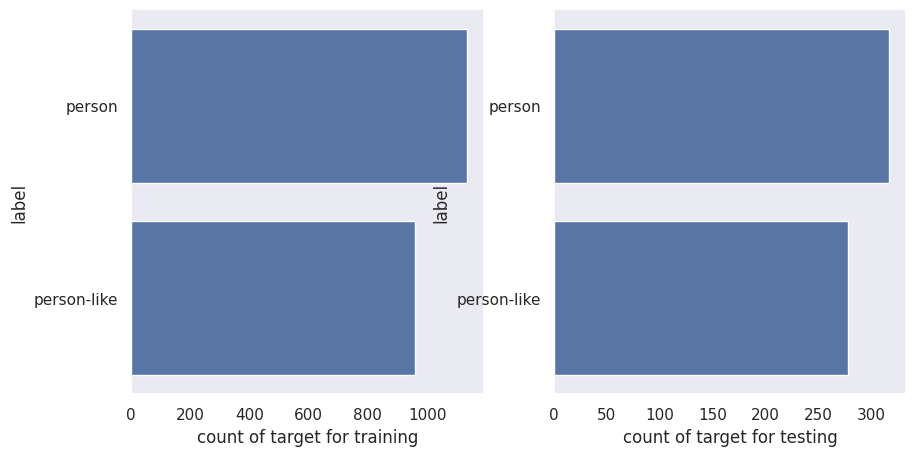

In [12]:
fig=plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.countplot(train_info['label'])
plt.xlabel('count of target for training')

plt.subplot(1,2,2)
sns.countplot(test_info['label'])
plt.xlabel('count of target for testing')

plt.show()

In [13]:
train_info.loc[train_info['name']=='image (101)']

,xmin,ymin,xmax,ymax,name,label
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person


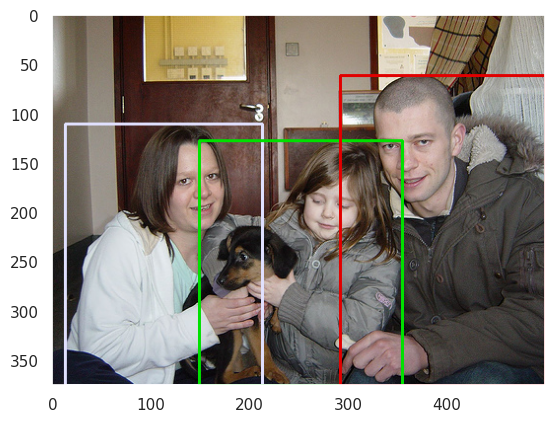

In [14]:
img=cv2.imread(train_path+'/image (101).jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

cv2.rectangle(img,(13,110),(213,375),(225,225,255),2)
cv2.rectangle(img,(149,127),(355,375),(0,225,0),2)
cv2.rectangle(img,(292,61),(500,375),(225,0,0),2)

plt.imshow(img)

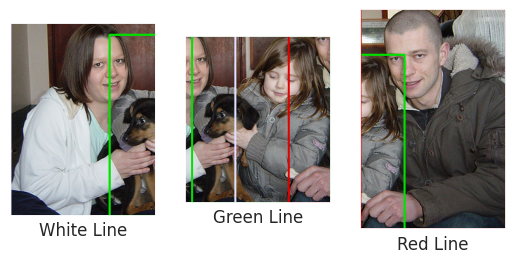

In [15]:
#  y-min, y-max , x-min , x-max
fig=plt.figure()

plt.subplot(1,3,1)
plt.imshow(img[110:375,13:213])
plt.xticks([])
plt.yticks([])
plt.xlabel('White Line')

plt.subplot(1,3,2)
plt.imshow(img[127:375,139:355])
plt.xticks([])
plt.yticks([])
plt.xlabel('Green Line')

plt.subplot(1,3,3)
plt.imshow(img[61:375,292:500])
plt.xticks([])
plt.yticks([])
plt.xlabel('Red Line')

plt.show()

In [16]:
def croppingFromImage(path,Data_information):
    cropped_image=[]
    label=[]
    for i in range(0,len(Data_information)):
        img=cv2.imread(path+'/'+Data_information['name'][i]+'.jpg',cv2.IMREAD_COLOR)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_=img[Data_information['ymin'][i]:Data_information['ymax'][i],Data_information['xmin'][i]:Data_information['xmax'][i]]
        cropped_image.append(img_)

        label.append(Data_information['label'][i])
    return cropped_image , label

In [19]:
import cv2

def croppingFromImage(path, Data_information):
    cropped_image = []
    label = []

    for i in range(len(Data_information)):
        # Get the full image path
        img_path = path + '/' + Data_information['name'][i] + '.jpg'

        # Read the image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        # Check if image was read correctly
        if img is None:
            print(f"Error: Image not found at {img_path}")
            continue

        # Convert image from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get bounding box coordinates and crop the image
        xmin, ymin, xmax, ymax = Data_information['xmin'][i], Data_information['ymin'][i], Data_information['xmax'][i], Data_information['ymax'][i]

        # Ensure the bounding box is within the image dimensions
        img_height, img_width, _ = img.shape
        xmin, ymin = max(0, xmin), max(0, ymin)
        xmax, ymax = min(img_width, xmax), min(img_height, ymax)

        # Crop the image using bounding box
        img_cropped = img[ymin:ymax, xmin:xmax]

        # Append cropped image and label
        cropped_image.append(img_cropped)
        label.append(Data_information['label'][i])

    return cropped_image, label

# Example usage
trainImage, trainLabel = croppingFromImage(train_path, train_info)
testImage, testLabel = croppingFromImage(test_path, test_info)
valImage, valLabel = croppingFromImage(val_path, val_info)


Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (421) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (421) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train

In [20]:
trainImage , trainLabel =croppingFromImage(train_path,train_info)
testImage , testLabel =croppingFromImage(test_path,test_info)

valImage,valLabel=croppingFromImage(val_path,val_info)

Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (420) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (421) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train/JPEGImages/image (421) (1).jpg
Error: Image not found at /content/drive/My Drive/Colab Notebooks/pedestrians dataset/Train/Train

In [21]:
print(len(trainImage) == len(trainLabel))
print(len(testImage) == len(testLabel))
print(len(valImage) == len(valLabel))

True
True
True


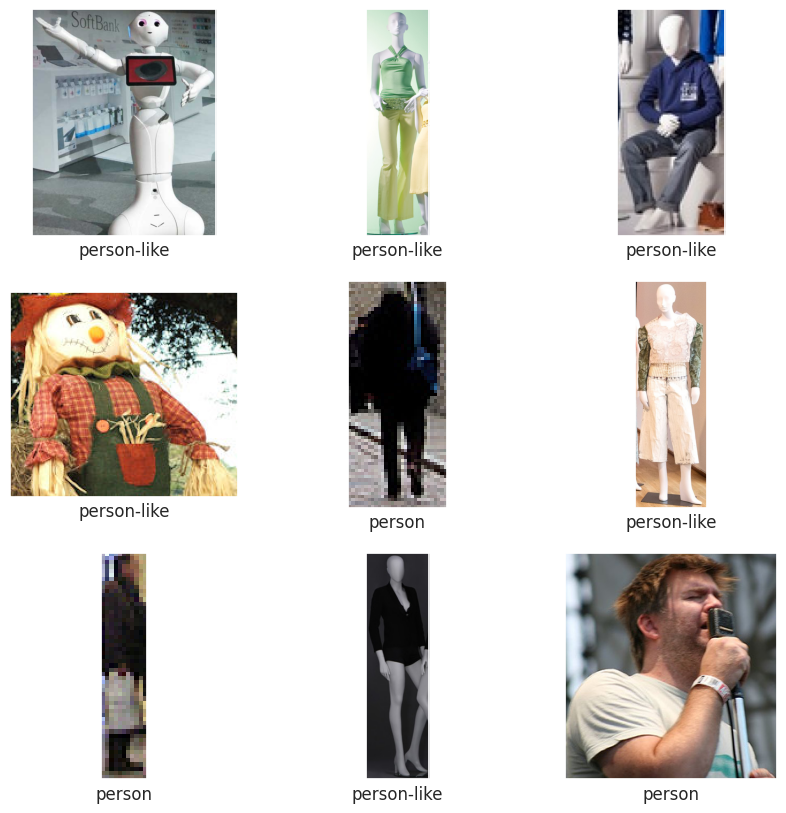

In [22]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(trainImage))
    plt.subplot(3,3,i)
    plt.imshow(trainImage[random])

    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

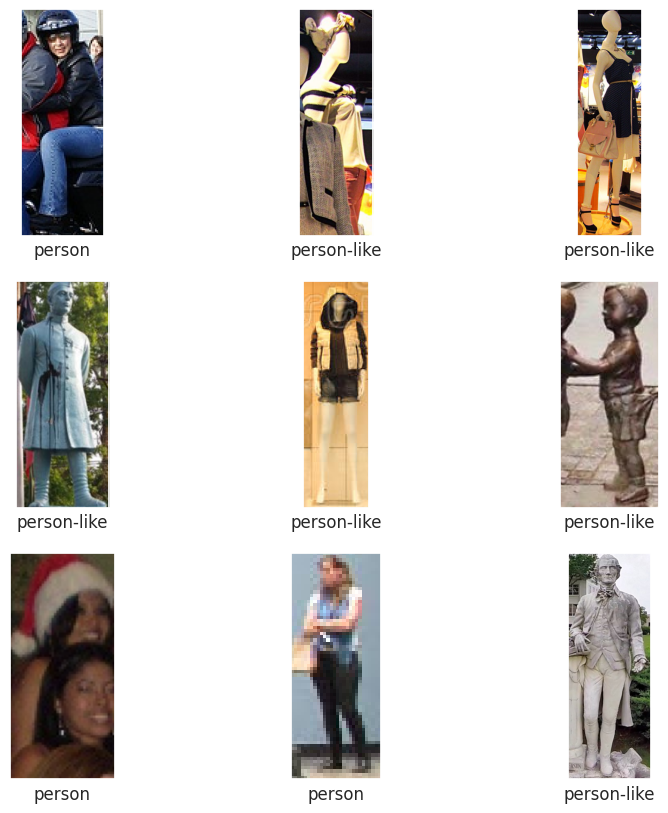

In [23]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(testImage))
    plt.subplot(3,3,i)
    plt.imshow(testImage[random])
    plt.xlabel(testLabel[random])
    plt.xticks([])
    plt.yticks([])

In [24]:
trainShapes=[]
testShapes=[]
for i in trainImage :
    trainShapes.append(i.shape)
for i in testImage :
    testShapes.append(i.shape)

In [25]:
pd.Series(trainShapes).value_counts()[:10]

,count
"(374, 499, 3)",4
"(162, 58, 3)",2
"(280, 252, 3)",2
"(151, 60, 3)",2
"(358, 271, 3)",2
"(95, 43, 3)",2
"(44, 34, 3)",2
"(101, 49, 3)",2
"(101, 32, 3)",2
"(284, 92, 3)",2


In [26]:
pd.Series(testShapes).value_counts()[:10]

,count
"(85, 52, 3)",2
"(128, 58, 3)",2
"(128, 47, 3)",2
"(120, 37, 3)",2
"(171, 74, 3)",2
"(105, 81, 3)",2
"(506, 449, 3)",1
"(225, 128, 3)",1
"(180, 94, 3)",1
"(187, 85, 3)",1


In [27]:
def resizing(data,size):
    resizing=[]
    for i in data:
        resizing.append(cv2.resize(i,(size,size)))

    return resizing

In [28]:
s=140
X_train,X_test,X_Val=resizing(trainImage,s),resizing(testImage,s),resizing(valImage,s)

In [29]:
labeling=preprocessing.LabelEncoder()
y_train=labeling.fit_transform(trainLabel)
y_test=labeling.fit_transform(testLabel)
y_val=labeling.fit_transform(valLabel)

In [30]:
labeling.classes_

array(['person', 'person-like'], dtype='<U11')

In [31]:
VGG_Model=VGG16(weights='imagenet',include_top=False,input_shape=(s,s,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [32]:
for layer in VGG_Model.layers:
    layer.trainable=False

In [33]:
VGG_Model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 140, 140, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 140, 140, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 140, 140, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 70, 70, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 70, 70, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 70, 70, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 35, 35, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 35, 35, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 35, 35, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 35, 35, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 17, 17, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 17, 17, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 17, 17, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
### Scaling
X_train,X_test,X_Val=np.asarray(X_train).astype(np.float32),np.asarray(X_test).astype(np.float32),np.asarray(X_Val).astype(np.float32)
X_train,X_test,X_Val=X_train/255.0,X_test/255.0,X_Val/255.0

In [35]:
print(X_train.shape)
print(X_test.shape)

(2066, 140, 140, 3)
(595, 140, 140, 3)


In [36]:
Training=np.concatenate((X_train,X_test))
Training_lbl=np.concatenate((y_train,y_test))

In [37]:
print(Training.shape)
print(Training_lbl.shape)

(2661, 140, 140, 3)
(2661,)


In [38]:
features_extracted=VGG_Model.predict(Training)
features_extracted_test=VGG_Model.predict(X_Val)

84/84 ━━━━━━━━━━━━━━━━━━━━ 656s 8s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step


In [39]:
flatten=features_extracted.reshape(features_extracted.shape[0],-1)
flatten_test=features_extracted_test.reshape(features_extracted_test.shape[0],-1)

In [40]:
print('train shape before Flatten ',features_extracted.shape)
print('train shape after Flatten ',flatten.shape)
print("="*50)
print('test shape before Flatten ',features_extracted_test.shape)
print('test shape after Flatten ',flatten_test.shape)

train shape before Flatten  (2661, 4, 4, 512)
train shape after Flatten  (2661, 8192)
test shape before Flatten  (333, 4, 4, 512)
test shape after Flatten  (333, 8192)


Training

In [41]:
model=Sequential()
model.add(Dense(64,input_shape=flatten.shape))
model.add(Activation('relu'))
model.add(Dropout(.7))

model.add(Dense(2))
model.add(Activation('sigmoid'))

In [42]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [44]:
print(flatten.shape)  # Should be (num_samples, 8192)


(2661, 8192)


In [46]:
flatten = flatten.reshape(flatten.shape[0], -1)
print(flatten.shape)  # Should now be (2661, 8192)


(2661, 8192)


In [47]:
fitting=model.fit(flatten,Training_lbl,batch_size=100,epochs=7,validation_data=(flatten_test,y_val))

Epoch 1/7


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 8192), dtype=float32). Expected shape (None, 2661, 8192), but input has incompatible shape (None, 8192)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 8192), dtype=float32)
  • training=True
  • mask=None

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

model = Sequential()
model.add(Dense(64, input_shape=(8192,)))  # Correct input shape
model.add(Activation('relu'))
model.add(Dropout(0.7))

model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam'
)


In [49]:
print(Training_lbl.shape)  # Should be (2661,)
print(y_val.shape)         # Should match validation samples


(2661,)
(333,)


In [50]:
fitting = model.fit(
    flatten, Training_lbl,
    batch_size=100, epochs=7,
    validation_data=(flatten_test, y_val)
)


Epoch 1/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5361 - loss: 0.9161 - val_accuracy: 0.7748 - val_loss: 0.5501
Epoch 2/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6766 - loss: 0.5699 - val_accuracy: 0.8468 - val_loss: 0.4555
Epoch 3/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7753 - loss: 0.5098 - val_accuracy: 0.8529 - val_loss: 0.3569
Epoch 4/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7929 - loss: 0.4755 - val_accuracy: 0.8408 - val_loss: 0.3818
Epoch 5/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8180 - loss: 0.4219 - val_accuracy: 0.8529 - val_loss: 0.3716
Epoch 6/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8222 - loss: 0.4115 - val_accuracy: 0.8529 - val_loss: 0.3507
Epoch 7/7
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8338 - loss: 0.3753 - val_accuracy: 0.8619 - val_loss: 0.3000


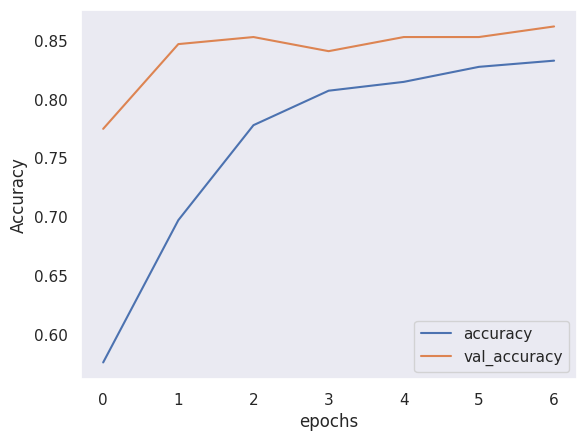

In [51]:
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy','val_accuracy'],loc='lower right')
plt.show()

In [54]:
fitting = model.fit(
    flatten, Training_lbl,
    batch_size=200, epochs=30,
    validation_data=(flatten_test, y_val)
)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9475 - loss: 0.1347 - val_accuracy: 0.8649 - val_loss: 0.3952
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9418 - loss: 0.1535 - val_accuracy: 0.8739 - val_loss: 0.3948
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9495 - loss: 0.1382 - val_accuracy: 0.8739 - val_loss: 0.4134
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9511 - loss: 0.1296 - val_accuracy: 0.8709 - val_loss: 0.4318
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9466 - loss: 0.1327 - val_accuracy: 0.8739 - val_loss: 0.4201
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9523 - loss: 0.1318 - val_accuracy: 0.8649 - val_loss: 0.4768
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9512 - loss: 0.1337 - val_accuracy: 0.8709 - val_loss: 0.4582
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9496 - loss: 0.1320 - val_accuracy: 0.8649 - v

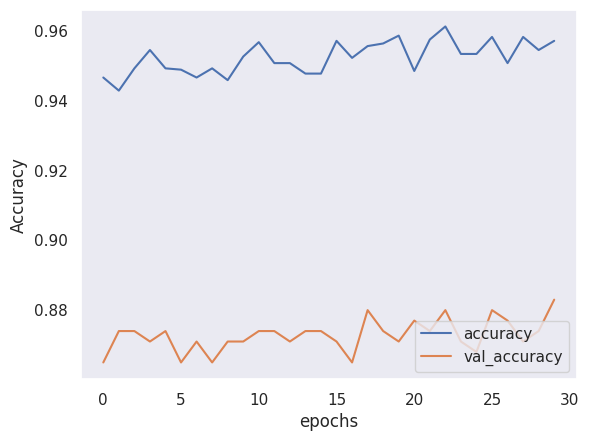

In [55]:
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy','val_accuracy'],loc='lower right')
plt.show()

In [56]:
pred=model.predict(flatten_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [57]:
def conver(prediction):
    if (prediction[0]>prediction[1]):return 'person'
    else:return 'Not person'

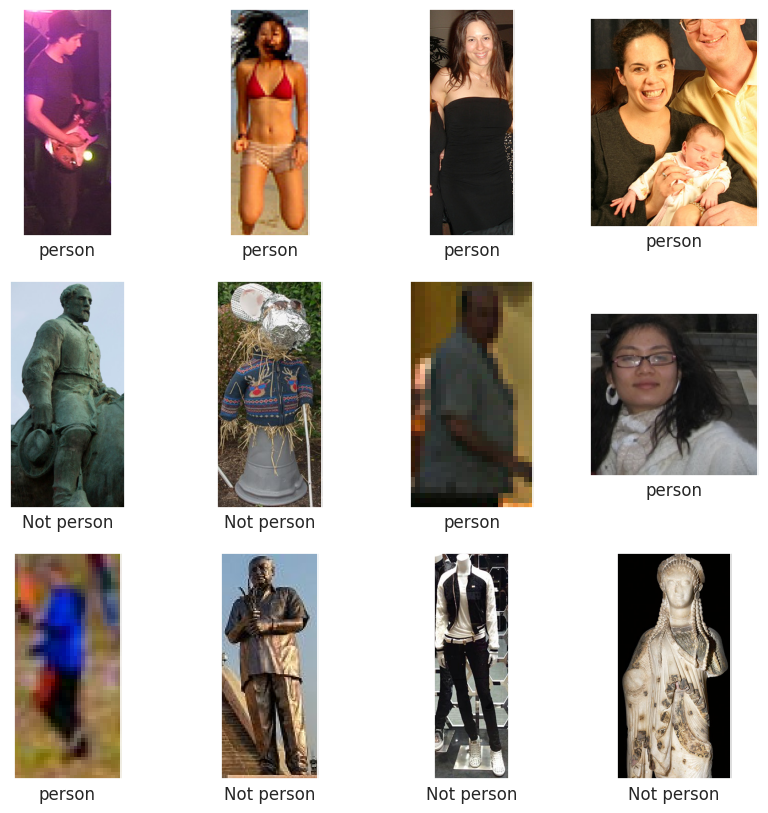

In [58]:
fig=plt.figure(figsize=(10,10))

for i in range (1,13):
    random=np.random.randint(0,len(valImage))
    plt.subplot(3,4,i)
    plt.imshow(valImage[random])
    label=conver(pred[random])
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])